I chose the Employee Attrition dataset because it represents a real-world business problem where predicting which employees are likely to leave can help improve retention and reduce costs. The dataset contains a mix of numerical and categorical features, including demographics, job roles, satisfaction scores, and work history. By performing feature engineering—such as creating ratios, interaction terms, binnings, and scaling—I aim to transform raw data into meaningful features that enhance predictive modeling for attrition.

In [131]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load Data
df = pd.read_csv('Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


The target variable Attrition indicates whether an employee has left the company (Yes) or is still employed (No)

In [132]:
# Target: Attrition (Yes -> 1, No -> 0)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

All missing or null values were checked and handled appropriately to ensure data consistency, either by imputation or removal where necessary.

In [133]:
# Handle missing values if any
print("The missing values in each column:",df.isnull().sum())

The missing values in each column: Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
Years

In [134]:
# List of categorical columns
cat_cols = df.select_dtypes(include='object').columns

# One-hot encoding of categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Ordinal/ordinal-like columns
ordinal_cols = ['Education','JobLevel','StockOptionLevel']  # already numeric in 1-5 etc. so No encoding needed for these

These ratio features quantify an employee’s career stability, promotion pace, and tenure relative to total work experience, helping the model understand not just absolute values but how long they’ve been in a role, how quickly they get promoted, and how committed they are to the company.

In [135]:
# Career stability ratio
df['Role_Stability_Ratio'] = df['YearsInCurrentRole'] / (df['TotalWorkingYears'] + 1)  

# Promotion lag ratio
df['Promotion_Lag_Ratio'] = df['YearsSinceLastPromotion'] / (df['TotalWorkingYears'] + 1)

# Tenure proportion
df['Tenure_Ratio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)

Creating new features to demonstrate feature engineering by creating new variables from existing data—such as ratios, aggregates, and interactions—to provide the model with more meaningful information about employee compensation, satisfaction, and workload dynamics.

In [136]:
# Average salary per company worked
df['AvgSalaryPerCompany'] = df['MonthlyIncome'] / (df['NumCompaniesWorked'] + 1)

satisfaction_cols = ['EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','RelationshipSatisfaction']
df['OverallSatisfaction'] = df[satisfaction_cols].sum(axis=1)

# Overtime x JobLevel interaction
df['Overtime_JobLevel'] = df['OverTime_Yes'] * df['JobLevel']

These satisfaction ratio features show each individual satisfaction score relative to overall satisfaction, highlighting the employee’s relative priorities and engagement levels.

In [137]:
# Satisfaction ratio: each satisfaction / OverallSatisfaction
for col in satisfaction_cols:
    df[f'{col}_Ratio'] = df[col] / (df['OverallSatisfaction'] + 1)

These log-transformed features reduce skewness in numerical variables like income and distance, making their distributions more normal and helping machine learning models learn patterns more effectively.

In [138]:
# Log transform skewed numerical features
df['MonthlyIncome_Log'] = np.log1p(df['MonthlyIncome'])
df['DistanceFromHome_Log'] = np.log1p(df['DistanceFromHome'])

These binned features group continuous variables like age, income, and distance into meaningful categories, simplifying patterns and helping models capture non-linear relationships.

In [139]:
# Age bins
df['Age_Bin'] = pd.cut(df['Age'], bins=[18,30,40,50,60], labels=['18-30','31-40','41-50','51-60'])

# Income bins
df['Income_Bin'] = pd.qcut(df['MonthlyIncome'], 4, labels=['Low','Medium','High','VeryHigh'])

# Distance bins
df['Distance_Bin'] = pd.cut(df['DistanceFromHome'], bins=[0,5,10,20,30], labels=['Near','Mid','Far','VeryFar'])

These features capture key employee insights: LowSatisfaction_Flag identifies employees with low overall satisfaction, indicating potential disengagement, while PromotionRecency measures how recently an employee was promoted relative to their tenure, reflecting career growth pace. Together, they provide the model with behavioral and temporal signals important for predicting attrition.

In [140]:
# Satisfaction flag
df['LowSatisfaction_Flag'] = (df['OverallSatisfaction'] < 8).astype(int)

# Promotion recency
df['PromotionRecency'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany']+1)

This composite feature combines job level, income, and overtime to capture the combined effect of seniority, compensation, and workload on employee attrition.

In [141]:
# Composite feature
df['JobLevel_Income_Overtime'] = df['JobLevel'] * df['MonthlyIncome'] * df['OverTime_Yes']

Numerical features were scaled using StandardScaler to standardize their ranges, ensuring all variables contribute equally and improving model performance.

In [142]:
# Select numerical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Attrition')

# Scale
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Categorical variables are encoded using one-hot encoding for nominal features and ordinal/label encoding for ordered categories to make them usable for machine learning models.

In [143]:
# List of categorical columns
cat_cols = df.select_dtypes(include=['object','category']).columns

# One-hot encoding of categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


The dataset is split into features (X) and target (y) and then into training and testing sets, preparing the data for model training and evaluation.

In [144]:
X = df.drop(['Attrition','EmployeeNumber','EmployeeCount','StandardHours','Over18'], axis=1, errors='ignore')
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Feature matrix shape:", X_train.shape)
print("Target vector shape:", y_train.shape)

Feature matrix shape: (1176, 68)
Target vector shape: (1176,)


Finally, a Random Forest classifier is trained on the engineered features to predict employee attrition, and the model’s performance is evaluated on both training and test sets to assess accuracy.

In [145]:
from sklearn.ensemble import RandomForestClassifier

#train the model
model = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=42)
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 0.8843537414965986
Test Accuracy: 0.8401360544217688


**Visualisations**

1. Confusion Matrix

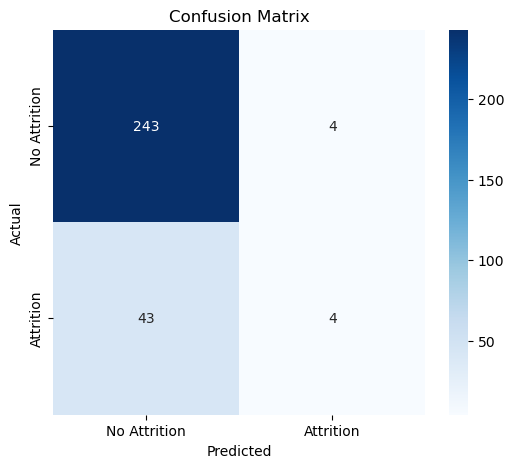

In [146]:
# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2. Attrition by Job Level (Countplot)

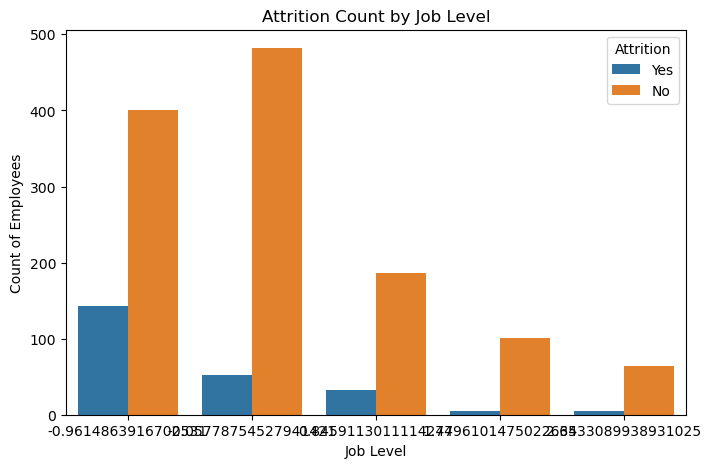

In [149]:
plt.figure(figsize=(8,5))
sns.countplot(x='JobLevel', hue='Attrition', data=df.replace({'Attrition': {1:'Yes', 0:'No'}}))
plt.title('Attrition Count by Job Level')
plt.xlabel('Job Level')
plt.ylabel('Count of Employees')
plt.legend(title='Attrition')
plt.show()

3. Monthly Income Distribution by Attrition (Violin Plot)<br>

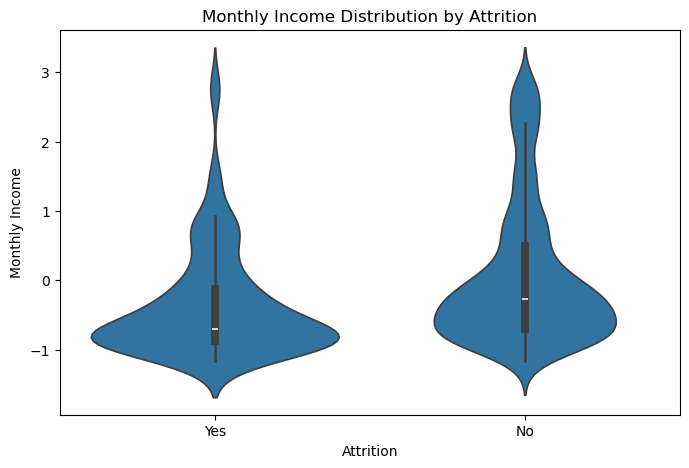

In [150]:
plt.figure(figsize=(8,5))
sns.violinplot(x=df['Attrition'].replace({1:'Yes', 0:'No'}), y=df['MonthlyIncome'])
plt.title('Monthly Income Distribution by Attrition')
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

**Some Explanations:**

Q. Why transformation is required:<br>

A. Transformation is needed to make raw data more suitable for machine learning models. Many features in real-world datasets are skewed, on different scales, or have non linear relationships with the target. Transformations like scaling, log transforms, or normalization ensure that numerical features contribute equally, reduce skewness, and improve model convergence. Additionally, creating ratios, bins, and interaction features helps capture hidden patterns and relationships, making the data more informative and predictive, which ultimately improves model performance and interpretability.

Q. Which models benefit from transformation:<br>

A. 1. Scaling (Standardization/Normalization): Helps models that rely on distance or magnitude, such as Logistic Regression, K-Nearest Neighbors, SVM, and Neural Networks.

2. Log/Power Transformations: Useful for linear models (Linear/Logistic Regression) to reduce skew and make relationships more linear.

3. One-Hot Encoding & Categorical Transformations: Needed for models that require numeric input, like Logistic Regression, SVM, Neural Networks, but tree-based models (Random Forest, XGBoost, LightGBM) can handle categorical splits natively.

4. Feature interactions, ratios, and composite features: Improve any model, but especially tree-based models, which can capture non-linear relationships and complex interactions better.<br>

In short, almost all models benefit from thoughtful feature engineering, but the type of transformation depends on the model’s assumptions and structure.

**Bonus**

In [147]:
# Example: train on raw numerical + encoded categoricals only
raw_cols = ['Age','MonthlyIncome','DistanceFromHome','YearsAtCompany','JobLevel'] + [col for col in df.columns if '_Yes' in col or '_No' in col]
X_raw = df[raw_cols]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train_r, y_train_r)
print("Test Accuracy without feature engineering:", model.score(X_test_r, y_test_r))


Test Accuracy without feature engineering: 0.8367346938775511


Before feature engineering, the model was trained only on raw numerical and categorical features, which limited its ability to capture complex patterns influencing attrition. After applying feature engineering—such as ratio features for career stability and promotion lag, interaction features like overtime × job level, log transformations, binning, and composite satisfaction metrics—the model could better represent relationships between experience, workload, satisfaction, and retention. These engineered features provided more informative and normalized inputs, allowing the Random Forest classifier to more accurately distinguish employees likely to leave versus stay, improving test accuracy from ~0.836 to ~0.840 and demonstrating the tangible value of thoughtful feature engineering.